## Bi-directional LSTM on IMDb dataset with Keras

Source: https://keras.io/examples/nlp/bidirectional_lstm_imdb/

In [ ]:
# Setup 
import numpy as np
import warnings

# Ignore FutureWarning from NumPy
warnings.simplefilter(action = 'ignore', category = FutureWarning)

from tensorflow import keras
from tensorflow.keras import layers
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.layers import Dense, LSTM
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from sklearn.metrics import f1_score, classification_report


max_features = 20000  # Only consider the top 20k words
max_len = 200 # Only consider the first 200 words of each movie review

# Build the model

# Input for variable-length sequences of integers
inputs = keras.Input(shape = (None,), dtype = "int32")
# Embed each integer in a 128-dimensional vector
x = layers.Embedding(max_features, 128)(inputs)
# Add 2 bidirectional LSTMs
x = layers.Bidirectional(layers.LSTM(64, return_sequences = True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
# Add a classifier
outputs = layers.Dense(1, activation = "sigmoid")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 128)         2560000   
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 2,757,761
Trainable params: 2,757,761
Non-train

In [ ]:
# Load the IMDB movie review sentiment data
(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(
    num_words = max_features, seed = 123)
print(len(x_train), "Training sequences")
print(len(x_test), "Test sequences")

# Use pad_sequence to standardize sequence length:
# This will truncate sequences longer than 200 words and zero-pad sequences 
# shorter than 200 words.
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen = max_len)
x_test = keras.preprocessing.sequence.pad_sequences(x_test, maxlen = max_len)

25000 Training sequences
25000 Test sequences


In [ ]:
# Split into validation since the load_data function won't allow us to do it manually
np.random.seed(123)
val_ind = np.random.randint(0, 24999, 5000)
x_val = x_train[val_ind]
y_val = y_train[val_ind]

In [ ]:
# Train and evaluate the model
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])
history = model.fit(x_train, 
                    y_train, 
                    batch_size = 32, 
                    epochs = 2, 
                    validation_data = (x_val, y_val))

Epoch 1/2
782/782 [==============================] - 37s 38ms/step - loss: 0.4221 - accuracy: 0.8045 - val_loss: 0.2383 - val_accuracy: 0.9058
Epoch 2/2
782/782 [==============================] - 29s 38ms/step - loss: 0.2204 - accuracy: 0.9192 - val_loss: 0.1502 - val_accuracy: 0.9468


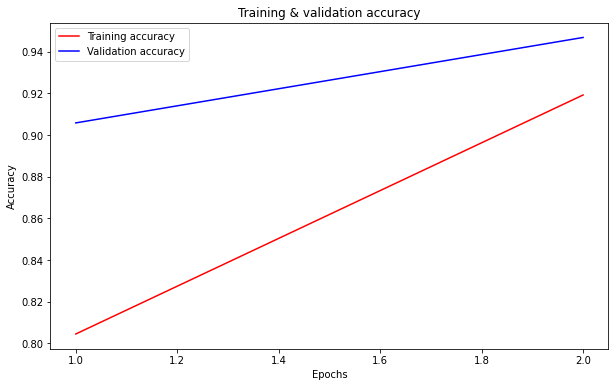

In [ ]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(acc) + 1)

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = (10.0, 6.0)
plt.plot(epochs, acc, '-r', label = 'Training accuracy')
plt.plot(epochs, val_acc, '-b', label = 'Validation accuracy')
plt.title('Training & validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = 'best')
plt.show()

In [ ]:
# Get validation accuracy + loss
scores = model.evaluate(x_val, y_val, batch_size = 32, verbose = 0)
print('Validation loss: %.4f' % scores[0])
print('Validation accuracy: %.4f' % scores[1])

Validation loss: 0.1502
Validation accuracy: 0.9468


In [ ]:
# Predict classes for test set
yhat_classes = model.predict(x_test, verbose = 0)
yhat_classes = np.concatenate([1 - yhat_classes, yhat_classes], axis = 1)
yhat_classes = np.argmax(yhat_classes, axis = 1)

# Get classification report
print("Classification Report")
print(classification_report(y_test, yhat_classes))

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.76      0.83     12500
           1       0.80      0.93      0.86     12500

    accuracy                           0.85     25000
   macro avg       0.86      0.85      0.85     25000
weighted avg       0.86      0.85      0.85     25000

